<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="800" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Estimating COVID-19's Effective Reproduction Number in Real-Time </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>Constructor Academy, 2025</center>



# Estimating COVID-19's $R_t$ in Real-Time
### Ekaterina, Nitin
### April 28, 2020

## Poisson distribution. Theory

Adapted from: Kevin Systrom - April 12, 2020
https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

-----------------

In any epidemic, $R_t$ is the measure known as the **effective reproduction number**.
It's the number of people who become infected per infectious person at time $t$.
The most well-known version of this number is the **basic reproduction number**:
$R_0$ when $t=0$. It is the average number of secondary infections produced by a
typical case of an infection in a population where everyone is susceptible.
**The R0 for measles in a population is 15**, then we would expect each new case
of measles to produce 15 new secondary cases. However, $R_0$ is a single measure
that does not adapt with changes in behavior and restrictions and is know for
diseases where reproduction dynamics is known.

The basic reproductive number is affected by several factors:

* The rate of contacts in the host population
* The probability of infection being transmitted during contact
* The duration of infectiousness.

As a pandemic evolves, increasing restrictions (or potential releasing of
restrictions) change $R_t$. Knowing the current $R_t$ is essential.
When $R_t \gt 1$, the pandemic will spread through the entire population.
If $R_t \lt 1$, the pandemic will grow to some fixed number less than the
population. The lower $R_t$, the more manageable the situation. The value of
$R_t$ helps us (1) understand how effective our measures have been controlling
an outbreak and (2) gives us vital information about whether we should increase
or reduce restrictions based on our competing goals of economic prosperity and
human safety. Well-respected epidemiologists argue that tracking $R_t$ is the
only way to manage through this crisis.

This example focuses on real-time tracking of $R_t$ in United States with an
exercise on Zurich data. More importantly, it is not useful to understand $R_t$
at a national level. Instead, to manage this crisis effectively, we need a local
(state, county and/or city) level granularity of $R_t$.

To read more on reproduction number:
https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function says how likely we are to see $k$ new cases, given a value
of $R_t$.

Any time you need to model 'arrivals' over some time period of time,
statisticians like to use the **Poisson Distribution**. Given an average arrival
rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is
distributed according to the Poisson distribution:
$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$


In [ ]:
import numpy as np
from scipy.stats import poisson
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
# vector of k from 0 to 69, step 1

k = range(70) #np.arange(69)

# Different values of Lambda
lambdas = [10, 20, 30, 40]

y = np.zeros((len(k), len(lambdas))) # initialize an empty matrix

# Evaluated the Probability Mass Function (remember: poisson is discrete) for every lambda
for i in range(len(lambdas)):
  y[:,i] = poisson.pmf(k, lambdas[i])

# Show the resulting shape
print(y.shape)

(70, 4)


Let's plot it

In [ ]:
import seaborn as sns
sns.set_theme()

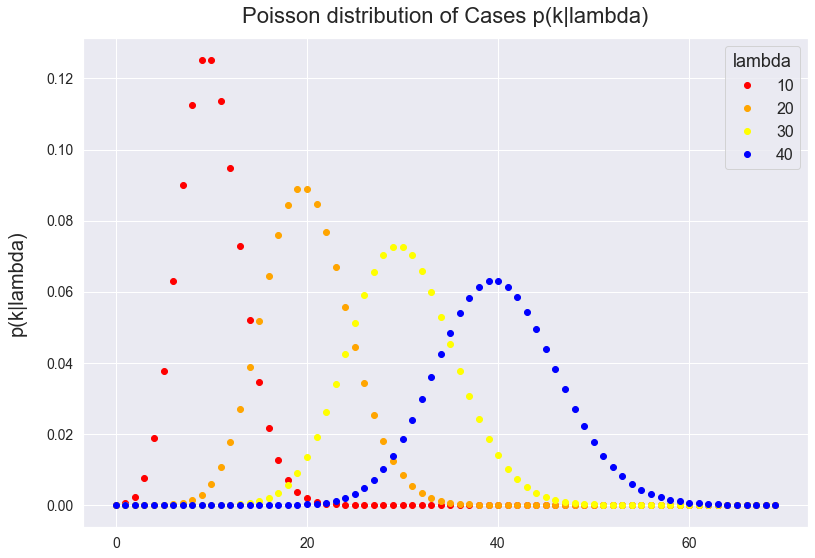

In [ ]:
pmf_df = pd.DataFrame(y, columns=['k10', 'k20', 'k30', 'k40'])

ax = pmf_df.plot(marker = 'o',
                 linestyle = 'None',
                 fontsize = 14,
                 figsize = (13,9),
                 color = ['red', 'orange', 'yellow', 'blue'],
                 xticks = [0, 20, 40, 60]
                 )

ax.set_ylabel("p(k|lambda)", fontdict = {'fontsize': 20}, labelpad = 20)
leg = ax.legend(fontsize = 16, title= 'lambda', labels = [lab[1:] for lab in pmf_df.columns])
leg.set_title('lambda', prop = {'size':18})
ax.set_title("Poisson distribution of Cases p(k|lambda)", pad = 15, fontdict = {'size':22})
ax;

The Poisson distribution says that if you think you're going to have $\lambda$
cases per day, you'll probably get that many, plus or minus some variation based
on chance.

But in our case, we know there have been $k$ cases and we need to know what
value of $\lambda$ is most likely. In order to do this, we fix $k$ in place
while varying $\lambda$. *This is called the likelihood function*.

For example, imagine we observe $k=20$ cases, and we want to know how likely
each $\lambda$ is:

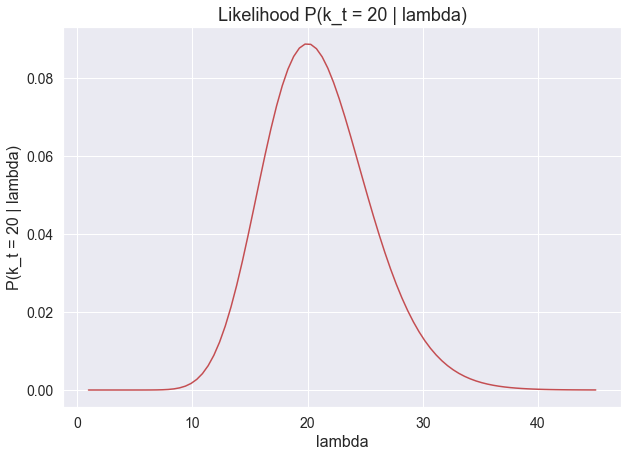

In [ ]:
k = 20
lam = np.linspace(start = 1, stop = 45, num = 90)
pmf = poisson.pmf(k, lam)

likelihood = pd.DataFrame(pmf, lam)
p_lh = likelihood.plot(legend = None,
                       fontsize = 14,
                       figsize = (10,7),
                       c = 'r',
                       title = "Likelihood P(k_t = 20 | lambda)")

p_lh.set_ylabel("P(k_t = 20 | lambda)", fontdict = {'fontsize': 16})
p_lh.set_xlabel("lambda", fontdict = {'fontsize': 16})
p_lh.title.set_size(18)

p_lh;

This says that if we see 20 cases, the most likely value of $\lambda$ is (not
surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and
saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was
40 and we saw 20.

Great. We have $P\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$
but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$.
We need to know the relationship between $\lambda$ and and $R_t$.

### Connecting $\lambda$ and $R_t$

The key insight to making this work is to realize there's a connection between
$R_t$ and $\lambda$. The derivation is beyond the scope of this notebook, but
here it is:
$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval
[about 7 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article).
Since we know every new case count on the previous day, we can now reformulate
the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To contiue our example, let's imagine a sample of new case counts $k$. What is
the likelihood of different values of $R_t$ on each of those days?



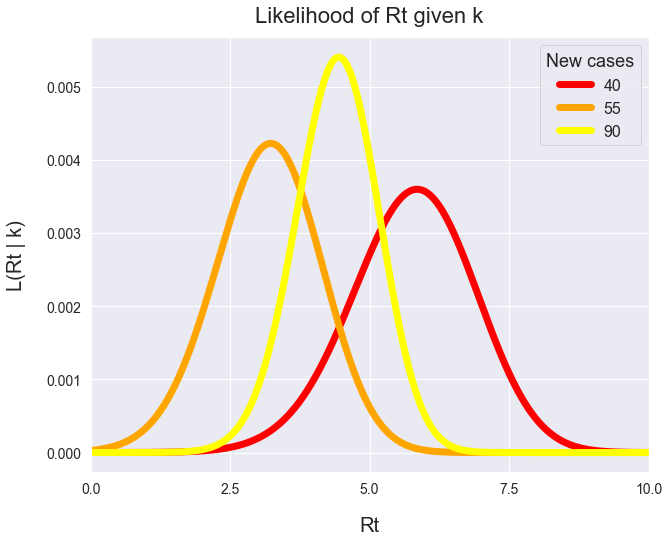

In [ ]:
k = np.array([20,40,55,90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(start = 0, stop = R_T_MAX, num = R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.

lam = np.dot(k[:-1].reshape(-1,1), np.exp(GAMMA * (r_t_range - 1).reshape(1,-1)), ) # taking k except last value

# Evaluate the likelihood on each day and normalize sum of each day to 1.0

likelihood_r_t = np.zeros((lam.shape[1], len(k)-1)) # initialize an empty matrix

for i in range(len(k)-1):
  likelihood_r_t[:,i] = poisson.pmf(k[1:][i], lam[i])

# sum of the elements of vector (along rows)
lh = np.sum(likelihood_r_t, axis = 0)

# normalization
likelihood_r_t = (lambda x: x/lh)(likelihood_r_t)

# Plot it
likelihood_df = pd.DataFrame(likelihood_r_t, r_t_range).reset_index()
likelihood_df.columns = ['Rt', 'k40', 'k55', 'k90']

#################
ax = likelihood_df.set_index('Rt').plot(
    fontsize = 14,
    figsize = (10,8),
    color = ['red', 'orange', 'yellow'],
    lw = 7,
    xlim = (0, 10),
    xticks = [0, 2.5, 5, 7.5, 10]
    )

ax.set_ylabel("L(Rt | k)", fontdict = {'fontsize': 20}, labelpad = 20)
ax.set_xlabel("Rt", fontdict = {'fontsize': 20}, labelpad = 20)
leg = ax.legend(fontsize = 16, labels = [40, 55, 90])
leg.set_title('New cases', prop = {'size':18})
ax.set_title("Likelihood of Rt given k", pad = 15, fontdict = {'size':22})
ax;

You can see that each day we have a independent guesses for $R_t$. As we can
guess the $R_t$ today would depend upon $R_t$ yesterday and so on.
**As we have learnt bayesian statistics provides a way to incorporate prior**
**knowledge into parameter estimation. The author here took following approach.**

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives
us a clue about the current value of $R_t$. We also, figure that the value of
$R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every
previous value of $R_{t-m}$ for that matter.

With these insights, the authors use Bayes' rule to update their beliefs about
the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:
$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$
is equal to:

- The likelihood of seeing $k$ new cases given $R_t$ times ...
- The prior beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use
yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will
assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$,
so $$P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$$, where $\sigma$ is a
**hyperparameter** (see below on how we estimate $\sigma$).

So on day one:
$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:
$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

etc.

**The goal is to combine the information we have about previous days with the**
**current day. To do this,  Bayes' theorem can be used.**

### Performing the Bayesian Update

To perform the Bayesian update, we need to **multiply the likelihood by the**
**prior (which is just the previous day's likelihood)** to get the posteriors.
Let's do that using the cumulative product of each successive day:


In [ ]:
# apply cumulative product to likelihood (along the columns)
posteriors = np.cumprod(likelihood_r_t, axis = 1)

# sum of the elements of vector (along rows)
ps = np.sum(posteriors, axis = 0)

# normalization
posteriors = np.apply_along_axis(lambda x:x/ps, 1, posteriors)


####  Plot it

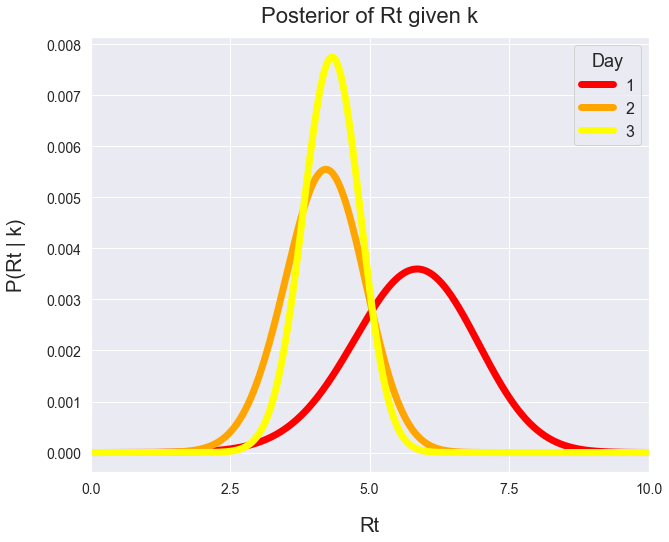

In [ ]:
posteriors_df = pd.DataFrame(posteriors, r_t_range).reset_index()
posteriors_df.columns = ['Rt', 'd1', 'd2', 'd3']

ax = posteriors_df.set_index('Rt').plot(
    fontsize = 14,
    figsize = (10,8),
    color = ['red', 'orange', 'yellow'],
    lw = 7,
    xlim = (0, 10),
    xticks = [0, 2.5, 5, 7.5, 10]
    )

ax.set_ylabel("P(Rt | k)", fontdict = {'fontsize': 20}, labelpad = 20)
ax.set_xlabel("Rt", fontdict = {'fontsize': 20}, labelpad = 20)
leg = ax.legend(fontsize = 16, labels = [1, 2, 3])
leg.set_title('Day', prop = {'size':18})
ax.set_title("Posterior of Rt given k", pad = 15, fontdict = {'size':22})
ax;


Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's
because we have no information other than that day. However, when we update the
prior using Day 2's information, you can see the curve has moved left, but not
nearly as left as the likelihood for Day 2 from above. This is because Bayesian
updating uses information from both days and effectively averages the two. Since
Day 3's likelihood is in between the other two, you see a small shift to the
right, but more importantly: a narrower distribution. We're becoming more
confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the
most likely value of $R_t$ each day?"

In [ ]:
# most likely values
mlv_day1, mlv_day2, mlv_day3 = [round(posteriors_df.set_index('Rt')[day].idxmax(), 3) for day in ['d1', 'd2', 'd3']]

print(
    "Most likely Rt values", "_"*20, "",
    f"Day 1: {mlv_day1}",
    f"Day 2: {mlv_day2}",
    f"Day 3: {mlv_day3}",
    sep = '\n'
)

Most likely Rt values
____________________

Day 1: 5.85
Day 2: 4.22
Day 3: 4.33


# Section 1.1  Show day by day prior, likelihood and posterior

Now, when we know what a prior, a posterior and a likelihood are, we can try to
show all of these in one plot.
Remember that on Day 1, our posterior matches Day 1's likelihood? Day 2 though
was updated. Let's show how it happens.  

### Exercise

Plot prior, likelihood and posterior for each day

We provide an example for the day1

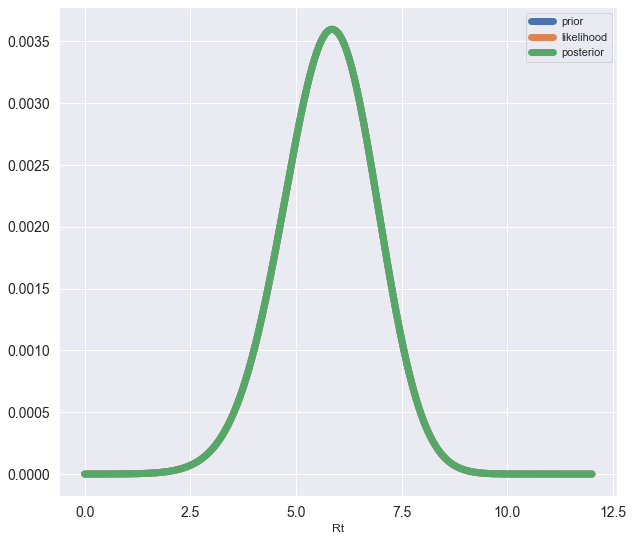

In [ ]:
prior1 = likelihood_df.iloc[:,1]
likelihood1 = likelihood_df.iloc[:,1]
posterior1 = posteriors_df.iloc[:,1]

day1 = pd.DataFrame({"prior":prior1, "likelihood": likelihood1, "posterior":posterior1, "Rt":r_t_range}).set_index("Rt")

day1.plot(
    fontsize = 14,
    figsize = (10,9),
    lw = 7,
    xticks = [0, 2.5, 5, 7.5, 10, 12.5]
    );

Continue for the day2 and day3

In [ ]:
#your code here


# Section 2.  Apply to real-life data

Let's take the US data from covidtracking.com

In [ ]:
url = 'covid_daily.csv'

states = pd.read_csv(url, usecols = ['submission_date', 'state', 'tot_cases'])
states.columns = ['date', 'state', 'positive']
states['date'] = pd.to_datetime(states['date'], format = "%m/%d/%Y")
states.sort_values(by = 'date', inplace = True)

states

,date,state,positive
34090,2020-01-22,TN,0
32630,2020-01-22,OK,0
19374,2020-01-22,WA,0
24670,2020-01-22,SD,0
53343,2020-01-22,NC,0
...,...,...,...
27436,2022-09-02,CO,1634692
55867,2022-09-02,KY,1546735
51874,2022-09-02,VI,22771
44521,2022-09-02,ID,490003


Taking a look at the state, we need to start the analysis when there are a
consistent number of cases each day. Find the last zero new case day and start
on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the
best view of the 'true' data we can, we've applied a rolling average filter to
the time series.

This is obviously an arbitrary choice, but you'd imagine the real world process
is not nearly as stochastic as the actual reporting.

In [ ]:
# prepare cases - smoothing the data
def prepare_cases(cases, cutoff):
    new_cases = np.diff(cases['positive'])
    #smoothed = pd.rolling_mean(pd.Series(new_cases), freq = 7, center = True, how = "extend")
    smoothed = pd.Series(new_cases).rolling(7, center = True, min_periods = 1).mean()

    idx_start = smoothed.where(smoothed > cutoff).idxmin() #first index after cutoff
    smoothed_cutoff = smoothed.iloc[idx_start:len(smoothed)].values #from idx_start (incl) to end

    original = new_cases[idx_start:len(smoothed)]
    date = cases['date'].iloc[idx_start:len(smoothed)].values
    df_prepared = pd.DataFrame(
        {
            'smoothed': smoothed_cutoff,
            'original': original,
        },
        index = date
    )

    return df_prepared

In [ ]:
# choose the state and cutoff value
state_name = 'NY'
cutoff = 25
cases =  states.query('state == "NY"')
cases

,date,state,positive
20572,2020-03-02,NY,0.0
20556,2020-03-03,NY,1.0
20538,2020-03-04,NY,1.0
20510,2020-03-05,NY,3.0
20477,2020-03-06,NY,25.0
...,...,...,...
261,2021-03-03,NY,1650184.0
205,2021-03-04,NY,1657777.0
149,2021-03-05,NY,1666733.0
93,2021-03-06,NY,1674380.0


In [ ]:
df_prepared = prepare_cases(cases, cutoff)

Plot the smoothed and original data

In [ ]:
df_prepared

,smoothed,original
2020-03-07,27.714286,24.0
2020-03-08,35.428571,28.0
2020-03-09,46.857143,63.0
2020-03-10,68.714286,44.0
2020-03-11,84.000000,56.0
...,...,...
2021-03-02,7359.285714,7704.0
2021-03-03,7246.285714,7593.0
2021-03-04,7414.833333,8956.0
2021-03-05,7737.800000,7647.0


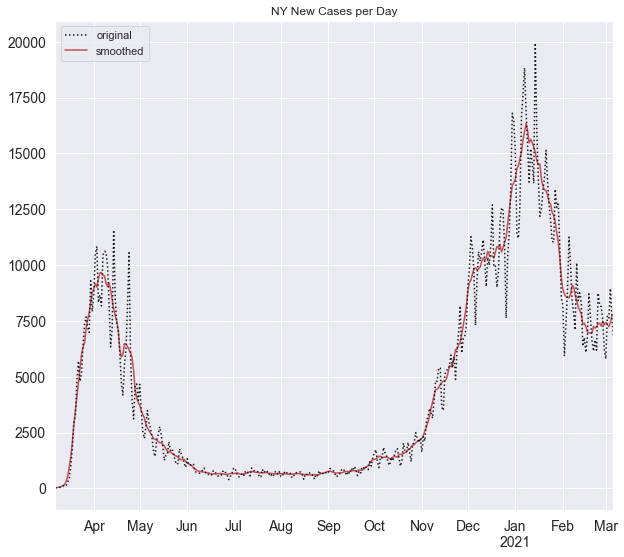

In [ ]:
df_prepared.plot(
    fontsize = 14,
    figsize = (10,9),
    title = "NY New Cases per Day",
    style = ['r-','k:'],
    legend = 'reverse'
    );

## Running the Algorithm

One thing to notice: choosing the Gaussian $\sigma$ for $P(R_t|R_{t-1})$.

The original approach simply selects yesterday's posterior as today's prior.
While intuitive, doing so doesn't allow for our belief that the value of $R_t$
has likely changed from yesterday. To allow for that change, we apply Gaussian
noise to the prior distribution with some standard deviation $\sigma$. The higher
$\sigma$ the more noise and the more we will expect the value of $R_t$ to drift
each day. Interestingly, applying noise on noise iteratively means that there
will be a natural decay of distant posteriors. This approach has a similar effect
of windowing, but is more robust and doesn't arbitrarily forget posteriors after
a certain time like my previous approach.

Specifically, windowing computed a fixed $R_t$ at each time $t$ that explained
the surrounding $w$ days of cases, while the new approach computes a series of
$R_t$ values that explains all the cases, assuming that $R_t$ fluctuates by
about $\sigma$ each day.

We have $sigma = 0.15$. If you are interested in process of selecting the value
of $sigma$ read the link at the top of this markdown notebook.

### Function for Calculating the Posteriors

To calculate the posteriors we follow these steps:

1. Calculate 𝜆- the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous
day from which to take the posterior. Based on info from the
[cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) we will choose a
Gamma with mean 7.

5. Loop from day 1 to the end, doing the following:

   - Calculate the prior by applying the Gaussian to yesterday's prior.
   - Apply Bayes' rule by multiplying this prior and the likelihood we
     calculated in step 2.
   - Divide by the probability of the data (also Bayes' rule)


In [ ]:
# your code here for the steps 1 to 4

sigma=0.15
sr = df_prepared['smoothed'] # smoothed data obtained by rolling average

# (1) Calculate Lambda
# Hint: See the chapter "Evaluating the Likelihood Function" above.

# (2) Calculate each day's likelihood

# - Initialize an empty matrix of size "r_t_range" x "len(sr) - 1"
# Hint: look for the inspiration in the chapter "Evaluating the Likelihood Function".

# - Fill each column (each day) with likelihood
# Hint: make `for` loop for each element of your `sr` vector, filling empty likelihood matrix with `dpois`   for current smoothed_data element and lambda. Again, the same as we did before.

# (3) Create the Gaussian Matrix
# This part is new. We'll use this matrix for the Bayesian update. Here we'll use sigma mentioned above.
# Create a square matrix of size `len(r_t_range)`, name it "process_matrix".
# With a `for` loop over the r_t_range elements, fill each column of "process_matrix" with the normal distribution (`dnorm`) of x = r_t_range, mean equal to a current element of r_t_range and sd = sigma.

# (3a) Normalize all rows of the "process_matrix" to sum to 1

# (4) Calculate the initial prior
# Create a vector of ones and normalize it to sum up to 1

# Create a DataFrame that will hold our posteriors for each day
# Insert our prior as the first posterior.
# You also can name the rows and columns according to your data





Now is the time to iteratively apply Bayes' rule

In [ ]:
# your code here for the step 5

# (5) Iteratively apply Bayes' rule

# Make a `for` loop with the iterator over all days minus the last one
# define previous_day and current_day

# (5a) Calculate the new prior (`current_prior`)
# multiply the "process_matrix" by the `posteriors` of previous day (previous day is defined in step before)
# for this use %*% - matrix-vector multiplication operator in R

# (5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
# multiply likelihood of current_day with `current_prior`

# (5c) Calcluate the denominator of Bayes' Rule P(k)
# your `denominator` is the sum of elements of `numerator`

# Execute full Bayes' Rule
# Do P(k|R_t)P(R_t) / P(k)


Final steps!

In [ ]:
# your code here

# find the values of the maximum likelihood of Rt in your posteriors. You can use `which.max` or similar command


Plot your findings

In [ ]:

# your code here
# just plot your result for each date


### Exercise

Try to do the same for **Swiss data**.
Is the situation better or worse than in US?

dataset:

In [ ]:
# your code here

# download data from here: https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv
# for 'positive' cases use column 'ncumul_conf'
# to change the date use: df['date'] = pd.to_datetime(df['date'])



### Bonus (No solution) - Compare different Kantons (Ticino, Zurich and Geneva)






